In [1]:
# %pylab notebook

import numpy as np 
import h5py
import matplotlib.pyplot as plt
# %matplotlib ipympl

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')

In [3]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''
def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr


def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        r200 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r200']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r200 #unit: r/r200
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][2]
        i+=1
    print(i)
                
    pcri = cosmo.critical_density(redshift).to('kpc-3Msun').value / 0.6777**2 / (1 + redshift)**3
    allvalue = allvalue / pcri   
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        return cal_median(rbin25[idnp], value25[idnp], 25)
    else:       
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        return cal_median(rbinvalue[idnp], allvalue[idnp], 50)

In [4]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

print(cosmo.critical_density(2).to('kpc-3Msun'))
print(cosmo.critical_density(0).to('kpc-3Msun') * ((1 - cosmo.Om0) + cosmo.Om0*3**3))
print(cosmo.critical_density(0).to('kpc-3Msun') / cosmo.h**2)

1145.2831616215892 solMass / kpc3
1145.2831616215892 solMass / kpc3
277.5366272458307 solMass / kpc3


324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
(0,)
324
input sample is 324
324
input sample is 324
(0,)
323
input sample is 323
324
input sample is 324
(0,)
323
input sample is 323
323
input sample is 323
(0,)
323
input sample is 322
323
input sample is 323
(0,)


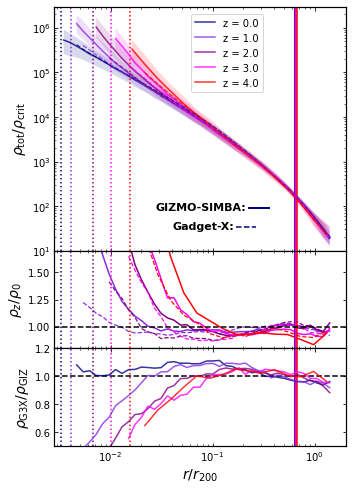

In [16]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)


snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

softl_GIZ = [0.0033, 0.0041, 0.0067, 0.0102, 0.0155]
softl_G3X = [0.0043, 0.0053, 0.0086, 0.0133, 0.0198]
#==========================================================

# GIZMO
for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Totdens',False,nGIZ[i])
        xmed25,ymed25,yerr25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Totdens',True,nGIZ[i])
        # idt = (yerr0[0] > 0)
        idt = np.where((yerr0[0] > 0) & (xmed0 > softl_GIZ[i]))[0]
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        
        xmed0_x,ymed0_x,yerr0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Totdens',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Totdens',True,nG3X[i])
        # idt_x = (yerr0_x[0] != 0)
        idt_x = np.where((yerr0_x[0] != 0) & (xmed0_x > softl_G3X[i]))[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
#         print('GIZ radius',xmed0[idt])
#         print('G3X radius',xmed0_x[idt_x])
        
    elif i <= 3:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Totdens',False,nGIZ[i])
        # idt = (yerr[0] > 0)
        idt = np.where((yerr[0] > 0) & (xmed > softl_GIZ[i]))[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Totdens',False,nG3X[i])
        # idt_x = (yerr_x[0] != 0)
        idt_x = np.where((yerr_x[0] != 0) & (xmed_x > softl_G3X[i]))[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Totdens',True,nGIZ[i])
        # idt = (yerr[0] > 0)
        idt = np.where((yerr[0] > 0) & (xmed > softl_GIZ[i]))[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Totdens',True,nG3X[i])
        # idt_x = (yerr_x[0] != 0)
        idt_x = np.where((yerr_x[0] != 0) & (xmed_x > softl_G3X[i]))[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed25_x[idt_x], c=colall[i], lw = 1.2, ls = '--')
        
        ax20.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
    print(idt[idt == True].shape)
     
GIZ_500 = [0.6401, 0.6406, 0.6450, 0.6543, 0.6633, 0.6703, 0.6723]
G3X_500 = [0.6449, 0.6483, 0.6464, 0.6505, 0.6621, 0.6665, 0.6708]

for i in range(5):
    ax1.axvline(GIZ_500[i], color = colall[i], ls = '-')
    ax10.axvline(GIZ_500[i], color = colall[i], ls = '-')
    ax20.axvline(GIZ_500[i], color = colall[i], ls = '-')
    
    ax1.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    ax10.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    ax20.axvline(softl_GIZ[i], color = colall[i], ls = ':')
    
ax1.text(0.0278,8e1,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.04,3e1,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.655,0.135))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.611,0.06))
ax1.add_artist(legend0)


#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$\rho_{\rm tot}/\rho_{\rm crit}$', fontsize = 14)
ax1.loglog()
ax1.legend( ncol = 1, loc = (0.47,0.65))
ax1.set_xticklabels([])

ax1.set_ylim(1e1,3e6)
ax1.set_xlim(2.8e-3,2)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(2.8e-3,2)
ax10.set_ylim(0.8,1.7)
# ax10.set_yscale('log')
ax10.set_xticklabels([])
# ax10.set_xlabel(r'$r/r_{200}$', fontsize = 14)
ax10.set_ylabel(r'$\rho_z/\rho_0$', fontsize = 14)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
# ax20.set_yscale('log')
ax20.set_xlim(2.8e-3,2)
ax20.set_ylim(0.5,1.2)

ax20.set_xlabel(r'$r/r_{200}$', fontsize = 14)
ax20.set_ylabel(r'$\rho_{\rm G3X}/\rho_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)
# ax10.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
plt.savefig('./figs/Totdens.pdf')